In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
from dance_evaluation import *
import matplotlib.pyplot as plt

In [ ]:
def calculate_metrics_with_oe(ref, calculated, tolerance=10):
    """
    Calculate Acc1, Acc2, Metric3, OE1, and OE2.
    Args:
        ref (np.ndarray): Reference BPMs.
        calculated (np.ndarray): Estimated BPMs.
        tolerance (float): Precision window (default 4%).
    Returns:
        dict: Dictionary with Acc1, Acc2, Metric3, OE1, and OE2 values.
    """
    # ref_tolerance = ref * tolerance
    ref_tolerance = tolerance
    # Acc1: Within 4% of reference BPM
    acc1_count = np.sum(np.abs(calculated - ref) <= ref_tolerance)
    
    # Acc2: Within 4% of reference BPM, double, or half
    acc2_count = np.sum(
        # (np.abs(calculated - ref) <= ref_tolerance) |
        (np.abs(calculated - 2 * ref) <= ref_tolerance) |
        (np.abs(calculated - ref / 2) <= ref_tolerance)
    )
    
    # # Metric3: Within 4% of 1x, 2x, 1/2x, 3x, 1/3x, 4x, 1/4x, 6x
    scales = [1, 2, 0.5, 3, 1/3]     # 3, 1/3, 4, 1/4, 6
    # metric3_count = 0
    # for scale in scales:
    #     metric3_count += np.sum(np.abs(calculated - ref * scale) <= ref_tolerance)
    
    # OE1: Overestimated BPM outside hierarchical relationships
    oe1_count = np.sum(
        (calculated > ref) &  # Overestimation
        ~np.any([np.abs(calculated - ref * scale) <= ref_tolerance for scale in scales], axis=0)  # Not within any scale
    )
    
    # OE2: Overestimated BPM within hierarchical relationships
    oe2_count = np.sum(
        (calculated > ref) &  # Overestimation
        np.any([np.abs(calculated - ref * scale) <= ref_tolerance for scale in scales], axis=0)  # Within any scale
    )
    
    total = len(ref)
    
    metrics = {
        "Acc1": (acc1_count / total) * 100,
        "Acc2": (acc2_count / total) * 100,
        # "OE1": (oe1_count / total) * 100,
        # "OE2": (oe2_count / total) * 100,
    }
    return metrics


In [2]:
base = "hand"
sname = "hand"

df_axis_z1 = pd.read_csv(f"./{base}/peraxis/{sname}_peraxis_zero_uni_50_150.csv")
df_axis_z2 = pd.read_csv(f"./{base}/peraxis/{sname}_peraxis_zero_bi_50_150.csv")
df_axis_p1 = pd.read_csv(f"./{base}/peraxis/{sname}_peraxis_p1_50_150.csv")
df_axis_p2 = pd.read_csv(f"./{base}/peraxis/{sname}_peraxis_p2_50_150.csv")

df_xyz = pd.read_csv(f"./{base}/xyz/{sname}_xyz_50_150.csv")


c = "a"
ref = df_axis_z1["bpm"].to_numpy()
# using zero uni point
tempo_x_z1 = df_axis_z1[f"X_{c}"].to_numpy()
tempo_y_z1 = df_axis_z1[f"Y_{c}"].to_numpy()
tempo_z_z1 = df_axis_z1[f"Z_{c}"].to_numpy()
# using zero bi point
tempo_x_z2 = df_axis_z2[f"X_{c}"].to_numpy()
tempo_y_z2 = df_axis_z2[f"Y_{c}"].to_numpy()
tempo_z_z2 = df_axis_z2[f"Z_{c}"].to_numpy()
# using one peaks
tempo_x_p1 = df_axis_p1[f"X_{c}"].to_numpy()
tempo_y_p1 = df_axis_p1[f"Y_{c}"].to_numpy()
tempo_z_p1 = df_axis_p1[f"Z_{c}"].to_numpy()
# using two peaks
tempo_x_p2 = df_axis_p2[f"X_{c}"].to_numpy()
tempo_y_p2 = df_axis_p2[f"Y_{c}"].to_numpy()
tempo_z_p2 = df_axis_p2[f"Z_{c}"].to_numpy()

tempo_xyz = df_xyz["tempoA"].to_numpy()

### oe1 oe2 acc1 acc2 m3

In [3]:
# Data for each experiment
experiments = {
    "zero_uni": [tempo_x_z1, tempo_y_z1, tempo_z_z1, tempo_xyz],
    "zero_bi": [tempo_x_z2, tempo_y_z2, tempo_z_z2, tempo_xyz],
    "peak_uni": [tempo_x_p1, tempo_y_p1, tempo_z_p1, tempo_xyz],  # Replace ref for XYZ if not available
    "peak_bi": [tempo_x_p2, tempo_y_p2, tempo_z_p2, tempo_xyz]   # Replace ref for XYZ if not available
}
axes = ["X", "Y", "Z", "XYZ"]

# Initialize results storage
results = {"experiment": [], "axis": [], "acc1": [], "acc2": []}

tolerance = 8
for exp_name, data in experiments.items():
    for axis_name, calculated in zip(axes, data):
        metrics = calculate_metrics_with_oe(ref, calculated, tolerance = tolerance)
        
        results["experiment"].append(exp_name)
        results["axis"].append(axis_name)
        results["acc1"].append(metrics["acc1"])
        results["acc2"].append(metrics["acc2"])

results_df = pd.DataFrame(results)

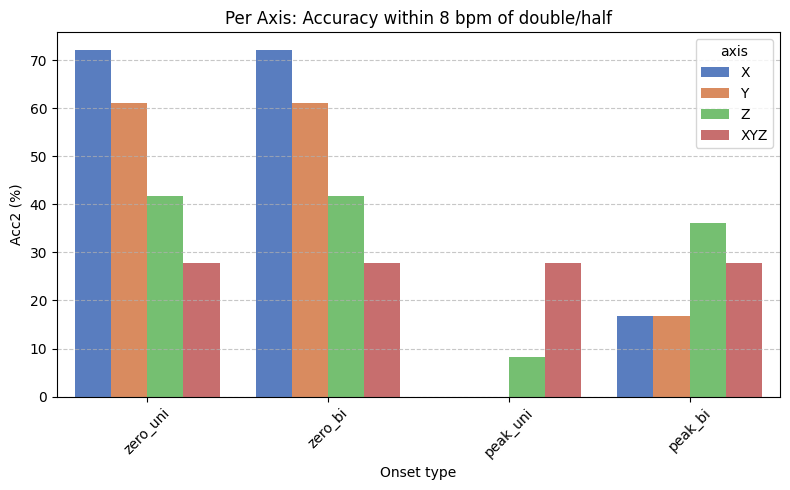

In [4]:
# Plot using Seaborn
plt.figure(figsize=(8, 5))  # Adjust figure size for better readability
sns.barplot(data=results_df, x="experiment", y="acc2", palette="muted", hue="axis")

# Customize plot
plt.xlabel("Onset type")
plt.ylabel("Acc2 (%)")
plt.title(f"Per Axis: Accuracy within {tolerance} bpm of double/half")
plt.xticks(rotation=45)  # Rotate labels if necessary
# plt.ylim(0, 100)  # Set consistent y-axis limits
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save and display the plot
plt.tight_layout()
plt.savefig(f'./{base}/plots/{sname}_per_axis_acc2.png')
plt.show()

In [ ]:
# Plot metrics for each experiment
for exp_name in results_df["experiment"].unique():
    exp_data = results_df[results_df["experiment"] == exp_name]
    
    x = np.arange(len(exp_data))  # Axes: X, Y, Z, XYZ
    bar_width = 0.15

    plt.figure(figsize=(5, 5))
    plt.bar(x - 2 * bar_width, exp_data["Acc1"], bar_width, label="Acc1 (Strict)", color="blue")
    plt.bar(x - bar_width, exp_data["Acc2"], bar_width, label="Acc2 (Double/Half)", color="green")
    # plt.bar(x, exp_data["Metric3"], bar_width, label="Metric3 (Subdivisions)", color="purple")
    plt.bar(x + bar_width, exp_data["OE1"], bar_width, label="OE1 (Strict Overestimation)", color="orange")
    plt.bar(x + 2 * bar_width, exp_data["OE2"], bar_width, label="OE2 (Hierarchical Overestimation)", color="red")

    # Customize plot
    plt.xticks(x, exp_data["axis"])
    plt.xlabel("Axes")
    plt.ylabel("Percentage (%)")
    plt.title(f"Per Axis - Left Foot -{exp_name}")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.ylim(0, 100)
    plt.savefig(f'./plots/left_foot_{exp_name}.png')
    plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(ref, bins=10)